# Memoría Caché y Rendimiento

In [1]:
import numba 
from numba import jit, njit
import numpy as np
import time

In [2]:
# Medición de tiempos

class Timer:

    def __enter__(self):
        self.start = time.time()
        return self

    def __exit__(self, *args):
        self.end = time.time()
        self.interval = self.end - self.start

## Sumar los elementos de una matriz

En este ejercicio, vamos a comprobar de manera empírica como el patrón de acceso a los datos puede mejorar el aprovechamiento de las memorias caché del sistema. Para ello, se utilizarán los dos funciones para sumar todos los elementos de una matriz, empleando un patrón de acceso diferente.

In [3]:
# Funciones de suma de elementos de matriz

@jit(nopython=True)
def slow(mat):
    """Sum all matrix values."""
    value = 0
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            value += mat[j, i]

    return value

@jit(nopython=True)
def fast(mat):
    """Sum all matrix values."""
    value = 0
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            value += mat[i, j]

    return value

In [4]:
# Comparamos contra numpy para confirmar que ambas son correctas
matrix = np.random.rand(10, 10)

# Numpy
print("--- Numpy ---")
print(matrix.sum())
print("")

# Python
print("--- Python ---")
print(slow.py_func(matrix))
print("")
print(fast.py_func(matrix))
print("")

#np.testing.assert_array_equal(slow.py_func(matrix), matrix.sum())
#np.testing.assert_array_equal(fast.py_func(matrix), matrix.sum())

# Numba
print("--- Numba ---")
print(slow(matrix))
print("")
print(fast(matrix))

#np.testing.assert_array_equal(slow(matrix), matrix.sum())
#np.testing.assert_array_equal(fast(matrix), matrix.sum())

--- Numpy ---
47.9738108842104

--- Python ---
47.97381088421039

47.97381088421037

--- Numba ---
47.97381088421039

47.97381088421037


Slow - Size 1000 Time 0.06559014320373535
Fast - Size 1000 Time 0.06253790855407715
Slow - Size 2000 Time 0.25640106201171875
Fast - Size 2000 Time 0.24885821342468262
Slow - Size 3000 Time 0.5816938877105713
Fast - Size 3000 Time 0.5580930709838867
Slow - Size 4000 Time 1.04618501663208
Fast - Size 4000 Time 1.0093379020690918
Slow - Size 5000 Time 1.6791367530822754
Fast - Size 5000 Time 1.6173677444458008
Slow - Size 6000 Time 2.4456067085266113
Fast - Size 6000 Time 2.3762471675872803
Slow - Size 7000 Time 3.3218560218811035
Fast - Size 7000 Time 3.198019027709961


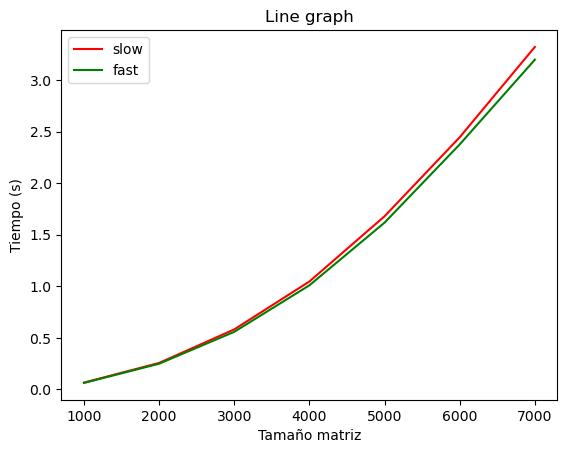

In [5]:
# Medimos los tiempos de ejecución de ambas funciones en Python
import matplotlib.pyplot as plt

x = []
y = []
z = []

for i in range(1000, 8000, 1000):
  
    matrix = np.random.rand(i, i)
    x.append(i)

    # Slow
    with Timer() as t:
      slow.py_func(matrix)
      
    result = t.interval
    
    print(f"Slow - Size {i} Time {result}")
    y.append(result)

    # Fast
    with Timer() as t:
      fast.py_func(matrix)
    
    result = t.interval
    
    print(f"Fast - Size {i} Time {result}")
    z.append(result)

# plotting
plt.title("Line graph")
plt.xlabel("Tamaño matriz")
plt.ylabel("Tiempo (s)")
plt.plot(x, y, color ="red", label="slow")
plt.plot(x, z, color ="green", label="fast")
plt.legend(loc="upper left")
plt.show()

## Pregunta 1
Como se puede observar, la función fast es más rápida ¿Cuál es la principal diferencia entre ambas funciones?

La única diferencia es en qué orden se accede a los elementos. En la función slow, se accede primero a las columnas y después a las filas. Por su parte, la función fast accede primero a las filas, pudiendo traer elementos contiguos en bloques de memoria. De esta forma, el procesador no necesita traer un bloque por cada operación de suma.  

## Ejercicio 1
Obten los resultados para las funciones compiladas con Numpy. Se recomienda realizar, para cada uno de los tamaños de matriz, al menos 5 repeticiones y obtener la media de esas ejecuciones como valor de tiempo.


In [6]:
# Medimos los tiempos de ejecución de ambas funciones en Python

# Se supone que las funciones ya están compiladas con Numpy por haberlas ejecutado antes 
# teniendo un decorador de Numba en su definición, así que tan solo habría que medir los 
# tiempos llamandolas sin el sufijo py_func. 

tamaño = []
tiempo_slow = []
tiempo_fast = []

n_iter = 10

for i in range(1000, 11000, 1000):
  
    matrix = np.random.rand(i, i)
    tamaño.append(i)

    # - - - - Slow - - - - 
    
    # 1. Creamos un array para almacenar 10 tiempos:
    results_slow = 0
  
    for _ in range(n_iter):
      
      # 2. Medimos el tiempo y lo guardamos en el array:
      
      with Timer() as t:
        slow(matrix)
      
      result = t.interval
      results_slow += result
    
    # 3. Calculamos la media de tiempos
      
    results_slow /= n_iter
      
    # 4. Lo añadimos a los tiempos de slow
    tiempo_slow.append(result)

    # - - - - Fast - - - - 
    
    # 1. Creamos un array para almacenar 10 tiempos:
    results_fast = 0
    
    for _ in range(n_iter):
      
      # 2. Medimos el tiempo y lo guardamos en el array:
      with Timer() as t:
        fast(matrix)
      
      result = t.interval  
      results_fast += result
    
    # 3. Calculamos la media de tiempos
      
    results_fast /= n_iter
      
    # 4. Lo añadimos a los tiempos de slow
    tiempo_fast.append(result)

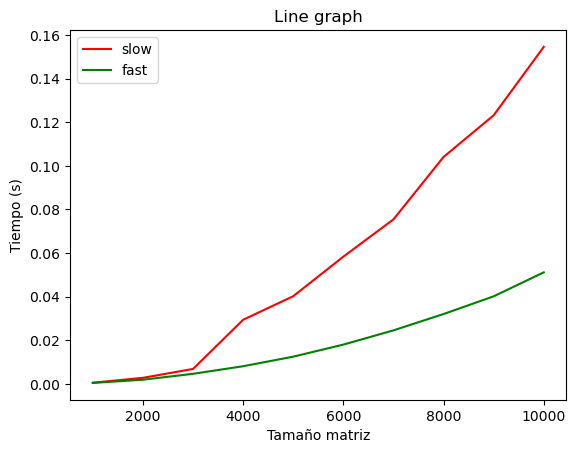

In [7]:
# Conviene visualizar los resultados:

plt.title("Line graph")
plt.xlabel("Tamaño matriz")
plt.ylabel("Tiempo (s)")
plt.plot(tamaño, tiempo_slow, color ="red", label="slow")
plt.plot(tamaño, tiempo_fast, color ="green", label="fast")
plt.legend(loc="upper left")
plt.show()

## Pregunta 2

¿Por qué para matrices pequeñas los tiempos de ejecución de ambas versiones son similares, pero se separan según aumenta el tamaño de la matriz?

Como se explicaba antes, la función slow tiene que traer a la caché muchos más bloques de la memoria RAM por acceder primero a columnas "aprovechando menos cada viaje". La diferencia entre traer 1000 y 2000 bloques es despreciable. No así la diferencia entre traer 1000 y 15000. De hecho, es probable que matrices tan grandes no quepan en caché, teniendo que ir a buscarlas directamente a la RAM, aumentando así, de forma tan exagerada, el tiempo para sumar los elementos. 

## Multiplicación de matrices

A continuación se muestra un código desarrollado para multiplicar dos matrices.

In [8]:
# Multiplicación de matrices lenta

@jit(nopython=True)
def matrix_multiplication_slow(A, B):
  m, n = A.shape
  _, p = B.shape
  C = np.zeros((m, p))
  for i in range(m):
    for k in range(p):
      for j in range(n):
        C[i, k] += A[i, j] * B[j, k]
  return C

matrix1 = np.random.rand(10, 10)
matrix2 = np.random.rand(10, 10)

# Se comprueba que el resultado es correcto
print(matrix1 @ matrix2)
print("")
print(matrix_multiplication_slow.py_func(matrix1, matrix2))
print("")
print(matrix_multiplication_slow(matrix1, matrix2))

[[3.15471591 2.80983143 2.63530863 2.71593763 1.96835507 1.77483643
  1.99446323 1.98673639 2.67406929 1.94382012]
 [1.96449955 1.83672458 2.16811386 1.78805061 1.06801581 1.28234676
  2.0600593  1.59908006 1.81537782 1.37580925]
 [3.39322696 3.90586712 3.88825201 3.05243489 2.61241164 2.48059836
  2.63869529 2.99855452 3.2049782  2.95924702]
 [1.86153136 2.56306296 2.55094571 1.94124072 1.98003854 1.59691627
  1.3617496  2.00343773 2.14905916 1.96530573]
 [2.47366957 2.63143483 2.52937618 2.12039551 1.52288842 1.65048744
  1.79410473 1.86672276 2.12329871 1.94780762]
 [3.18402631 2.53496569 2.55119623 2.6312351  1.86704049 1.51281963
  2.29264925 2.0705193  2.72185378 2.179184  ]
 [3.08306389 3.18590199 2.54846403 2.42214339 2.21734432 2.10666663
  2.35407303 2.23342683 2.45884924 2.10167179]
 [2.31901349 2.36767384 2.4807215  2.0349976  1.44354828 1.07563424
  1.6046001  1.68104451 1.76661423 2.18617805]
 [2.83516113 2.27639587 2.48466313 2.14716413 2.4036485  1.75614971
  1.906841  

In [9]:
# Comparar rendimiento
A = np.random.randn(200, 200)
B = np.random.randn(200, 200)

print('Python slow')
%timeit matrix_multiplication_slow.py_func(A, B)
print('Numba slow')
%timeit matrix_multiplication_slow(A, B)
print('numpy')
%timeit A @ B

Python slow
1.55 s ± 6.78 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Numba slow
3.93 ms ± 2.72 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
numpy
144 μs ± 5.41 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## Ejercicio 2

El código anterior es lento, incluso compilado con Numba. Desarrolle una versión más rápida haciendo uso de los conocimientos adquiridos en el ejercicio anterior.

In [10]:
# Multiplicación de matrices rápida
@jit(nopython=True)
def matrix_multiplication_fast(A, B):
  m, n = A.shape
  q, p = B.shape
  C = np.zeros((m, p))
  for i in range(m): # Primero filas de A 
    for j in range(n): # Luego columnas de A 
      for k in range(q): # Luego filas de B
        C[i, k] += A[i, j] * B[j, k]
  return C

In [11]:
# Comparar rendimiento
A = np.random.randn(200, 200)
B = np.random.randn(200, 200)

print('Python fast')
%timeit matrix_multiplication_fast.py_func(A, B)
print('Numba fast')
%timeit matrix_multiplication_fast(A, B)
print('numpy')
%timeit A @ B

Python fast
1.55 s ± 29.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Numba fast
998 μs ± 901 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
numpy
140 μs ± 2.2 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Es claro que la mejora en rendimiento para la versión compilada es un x3 aproximadamente. Aunque la versión sin compilar sigue siendo igual de lenta, puesto que el 95% del tiempo se la pasa llamando al intérprete, por lo que encontrar una mejoría era altamente improbable. 

## Ejercicio 3

Compare los tiempos de ejecución, para ambas versiones de la multiplicación de matrices, para tamaños de matrices de 1000 a 2000 con saltos de 100.

Nota: Dado que los tiempos son razonablemente altos, obtener la media de repeticiones es opcional.

In [12]:
# Medimos los tiempos de ejecución de ambas funciones de multiplicaciones de matrices en Python

# Podemos reciclar casi todo el código de antes:

tamaño = []
tiempo_slow = []
tiempo_fast = []

n_iter = 2

for i in range(1000, 2000, 100):
  
    matrix1 = np.random.rand(i, i)
    matrix2 = np.random.rand(i, i)
    tamaño.append(i)

    # - - - - Matrix Mult Slow - - - - 
    
    # 1. Creamos un array para almacenar 10 tiempos:
    results_slow = 0
  
    for _ in range(n_iter):
      
      # 2. Medimos el tiempo y lo guardamos en el array:
      
      with Timer() as t:
        matrix_multiplication_slow(matrix1, matrix2)
      
      result = t.interval
      results_slow += result
    
    # 3. Calculamos la media de tiempos
      
    results_slow /= n_iter
      
    # 4. Lo añadimos a los tiempos de slow
    tiempo_slow.append(result)

    # - - - - Matrix Mult Fast - - - - 
    
    # 1. Creamos un array para almacenar 10 tiempos:
    results_fast = 0
    
    for _ in range(n_iter):
      
      # 2. Medimos el tiempo y lo guardamos en el array:
      with Timer() as t:
        matrix_multiplication_fast(matrix1, matrix2)
      
      result = t.interval  
      results_fast += result
    
    # 3. Calculamos la media de tiempos
      
    results_fast /= n_iter
      
    # 4. Lo añadimos a los tiempos de slow
    tiempo_fast.append(result)

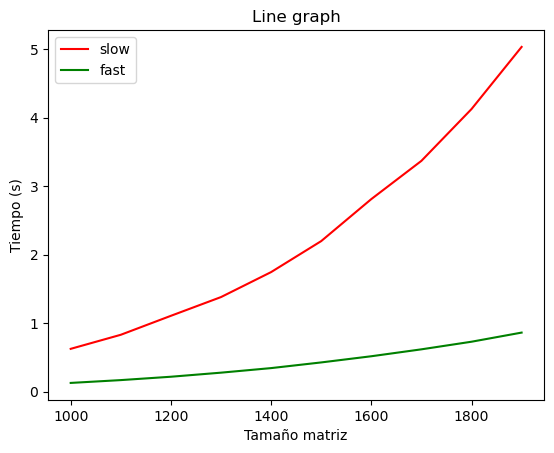

In [13]:
plt.title("Line graph")
plt.xlabel("Tamaño matriz")
plt.ylabel("Tiempo (s)")
plt.plot(tamaño, tiempo_slow, color ="red", label="slow")
plt.plot(tamaño, tiempo_fast, color ="green", label="fast")
plt.legend(loc="upper left")
plt.show()

## Pregunta 3
Justifique el efecto observado. ¿Se observan cambios de tendencia al variar los tamaños de las matrices? ¿A qué se deben?

La función fast casi parece lineal con respecto al tiempo para tamaños tan pequeños (es cúbica en realidad). Por su parte, slow nota en mucha mayor medida un aumento de tamaño a pesar de ser en realidad un algoritmo con igual coste en tiempo ($O(N^3)$). 

Por supuesto que se nota un cambio de tendencia. No se debe a la vectorización SIMD, pues ambas funciones juegan con la misma ventaja en ese sentido. Se debe a las mismas razones que exponíamos antes en el ejercicio 3. La función fast es capaz de traer bloques de memoria más eficientemente aprovechando en mayor medida cada bloque traído. Esto permite traer muchos menos bloques para hacer la misma operación y por tanto reducir drásticamente el tiempo de ejecución. 

## Ejercicio 4

Utilizando la versión más rápida de la multiplicación de matrices implementada con Numba, se pide analizar la paralelización de cada uno de los tres bucles de la multiplicación matricial clásica.

Cree tres versiones diferentes de la función de multiplicación, cada una paralelizando únicamente uno de los bucles mediante prange, es decir:

* Versión A: paralelizar el bucle exterior
* Versión B: paralelizar el bucle intermedio
* Versión C: paralelizar el bucle interior

El objetivo es determinar qué bucle es más adecuado para la paralelización.

En Numba, el número de hilos a utilizar puede configurarse mediante la función
Python "numba.set_num_threads(n)"

Para cada una de las tres versiones (A, B y C), y para un número de hilos que vaya desde 1 hasta el número máximo de núcleos disponibles (máximo 4):

* Mida el tiempo de multiplicar matrices cuadradas cuyos tamaños vayan desde 1000 hasta 2000, con incrementos de 200.
* Genere una gráfica independiente para cada valor del número de hilos (es decir, una gráfica para 1 hilo, otra para 2 hilos, etc.). En cada gráfica deben aparecer las tres versiones (A, B, C), comparando sus tiempos.

El resultado debe permitir visualizar qué bucle se beneficia más de la paralelización y cómo influye el número de hilos en el rendimiento.

In [14]:
# Multiplicación de matrices A
@jit(nopython=True, parallel=True)
def matrix_multiplication_fast_A(A, B):
  m, n = A.shape
  q, p = B.shape
  C = np.zeros((m, p))
  for i in numba.prange(m): # Paralelizamos el primer bucle
    for j in range(n): 
      for k in range(q):
        C[i, k] += A[i, j] * B[j, k]
  return C

  # Multiplicación de matrices B
@jit(nopython=True, parallel=True)
def matrix_multiplication_fast_B(A, B):
  m, n = A.shape
  q, p = B.shape
  C = np.zeros((m, p))
  for i in range(m):
    for j in numba.prange(n): # Paralelizamos el segundo bucle
      for k in range(q):
        C[i, k] += A[i, j] * B[j, k]
  return C

  # Multiplicación de matrices C
@jit(nopython=True, parallel=True)
def matrix_multiplication_fast_C(A, B):
  m, n = A.shape
  q, p = B.shape
  C = np.zeros((m, p))
  for i in range(m):
    for j in range(n): 
      for k in numba.prange(q): # Paralelizamos el tercer bucle
        C[i, k] += A[i, j] * B[j, k]
  return C

In [15]:
# Medimos los tiempos de ejecución de las 3 funciones de multiplicaciones de matrices en Python

# Podemos volver a reciclar casi todo el código de antes:

tamaño = []
tiempo_fast_A = []
tiempo_fast_B = []
tiempo_fast_C = []

n_iter = 2

for i in range(1000, 2000, 100):
  
    matrix1 = np.random.rand(i, i)
    matrix2 = np.random.rand(i, i)
    tamaño.append(i)

    # - - - - Matrix Mult A - - - - 
    
    # 1. Creamos un array para almacenar 10 tiempos:
    results_fast_A = 0
  
    for _ in range(n_iter):
      
      # 2. Medimos el tiempo y lo guardamos en el array:
      
      with Timer() as t:
        matrix_multiplication_fast_A(matrix1, matrix2)
      
      result = t.interval
      results_fast_A += result
    
    # 3. Calculamos la media de tiempos
      
    results_fast_A /= n_iter
      
    # 4. Lo añadimos a los tiempos de slow
    tiempo_fast_A.append(result)

    # - - - - Matrix Mult B - - - - 
    
    # 1. Creamos un array para almacenar 10 tiempos:
    results_fast_B = 0
  
    for _ in range(n_iter):
      
      # 2. Medimos el tiempo y lo guardamos en el array:
      
      with Timer() as t:
        matrix_multiplication_fast_B(matrix1, matrix2)
      
      result = t.interval
      results_fast_B += result
    
    # 3. Calculamos la media de tiempos
      
    results_fast_B /= n_iter
      
    # 4. Lo añadimos a los tiempos de slow
    tiempo_fast_B.append(result)
    
    # - - - - Matrix Mult C - - - - 
    
    # 1. Creamos un array para almacenar 10 tiempos:
    results_fast_C = 0
  
    for _ in range(n_iter):
      
      # 2. Medimos el tiempo y lo guardamos en el array:
      
      with Timer() as t:
        matrix_multiplication_fast_C(matrix1, matrix2)
      
      result = t.interval
      results_fast_C += result
    
    # 3. Calculamos la media de tiempos
      
    results_fast_C /= n_iter
      
    # 4. Lo añadimos a los tiempos de slow
    tiempo_fast_C.append(result)

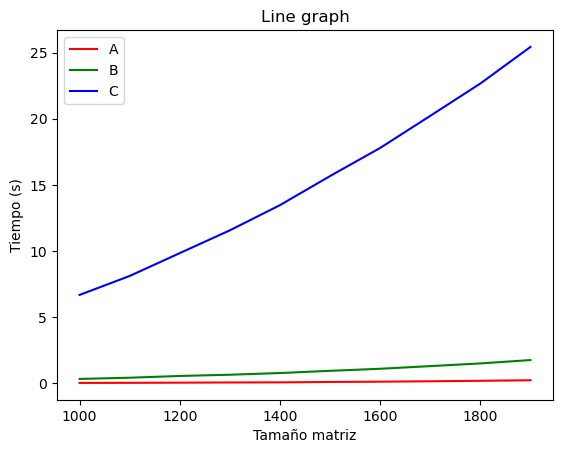

In [16]:
plt.title("Line graph")
plt.xlabel("Tamaño matriz")
plt.ylabel("Tiempo (s)")
plt.plot(tamaño, tiempo_fast_A, color ="red", label="A")
plt.plot(tamaño, tiempo_fast_B, color ="green", label="B")
plt.plot(tamaño, tiempo_fast_C, color ="blue", label="C")
plt.legend(loc="upper left")
plt.show()

## Pregunta 4
¿Cuál de los tres bucles resulta más adecuado para aplicar paralelización en la multiplicación de matrices? Explique y justifique su respuesta basándose en los resultados obtenidos y en las características del algoritmo.

Es evidente que la mejor paralelización es la primera, la A, en la que se paraleliza el primer bucle. Cuanto más externo sea el bucle, mayor número de operaciones acaparas al paralelizar creando "tareas globales más grandes y pesadas". Técnicamente es más fácil de paralelizar 8 operaciones grandes que 8 millones de operaciones unitarias (al menos si lo vas a ejecutar usando CPU). Por tanto, es lógico pensar que paralelizar el primer bucle es la mejor alternativa, pues no excluyes de la paralelización a ninguna operación. 